In [1]:
import numpy as np
import matplotlib.pyplot as plt
from theano import shared, function
import theano.tensor as T
from theano.gradient import jacobian
from utils import backprop_decision_boundary
from sklearn.datasets import make_circles
plt.style.use('ggplot')
%matplotlib inline

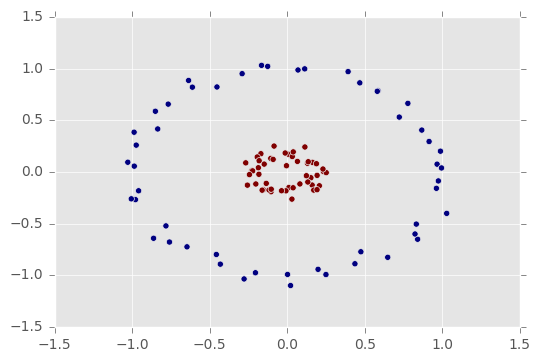

In [2]:
X, Y = make_circles(factor=0.2, noise=0.05)
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [3]:
from sklearn.preprocessing import OneHotEncoder
Y = OneHotEncoder().fit_transform(Y.reshape(-1, 1)).toarray()

In [4]:
rng = np.random.RandomState(12345)
x, y = T.dmatrices('xy')
w1 = shared(rng.rand(2, 3), name="w1")
b1 = shared(rng.rand(1, 3), name="b1")
w2 = shared(rng.rand(3, 2), name="w2")
b2 = shared(rng.rand(1, 2), name="b2")

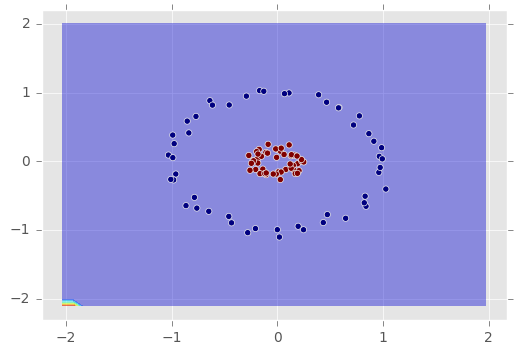

In [5]:
l1_activation = T.dot(x, w1) + b1.repeat(x.shape[0], axis=0)
_get_l1_activation = function([x], l1_activation)

l1_op = 1 / (1 + T.exp(-l1_activation))
_get_l1_op = function([x], l1_op)

l2_activation = T.dot(l1_op, w2) + b2.repeat(l1_op.shape[0], axis=0)
_get_l2_activation = function([x], l2_activation)

l2_op = 1 / (1 + T.exp(-l2_activation))
_get_l2_op = function([x], l2_op)

loss = T.sum((l2_op - y) ** 2) / (2 * x.shape[0])
get_loss = function([x, y], loss)

hypothesis = predict = function([x], l2_op)

backprop_decision_boundary(hypothesis, X, Y, True)

# Backpropagation

$$ \delta_{i}^{n_{l}} = \frac{\partial}{\partial z_{i}} \frac{1}{2} \|y - H(x; w, b)\|^{2} = -(y_{i} - a_{i}^{n_{l}}) . f'(z_{i}^{n_{l}})$$

In [6]:
del_3_rhs = - (y - l2_op) * jacobian(T.sum(T.sum(l2_op)), wrt=l2_activation)
_get_del_3_rhs = function([x, y], del_3_rhs)

del_3_lhs = jacobian(0.5 * T.sum((y - l2_op)**2), wrt=l2_activation)
_get_del_3_lhs = function([x, y], del_3_lhs)

xx = _get_del_3_lhs(X, Y)
yy = _get_del_3_rhs(X, Y)
print(np.allclose(xx, yy))

True


In [7]:
del_3 = jacobian(0.5 * T.sum((y - l2_op)**2), wrt=l2_activation)
_get_del_3 = function([x, y], del_3)

del_2 = T.dot(del_3_lhs, w2.T) * jacobian(T.sum(T.sum(l1_op)), wrt=l1_activation)
_get_del_2 = function([x, y], del_2)

## calculating gradients

In [8]:
grad_w2 = T.dot(l1_op.T, del_3)
grad_b2 = del_3.sum(0)
grad_w1 = T.dot(x.T, del_2)
grad_b1 = del_2.sum(0)

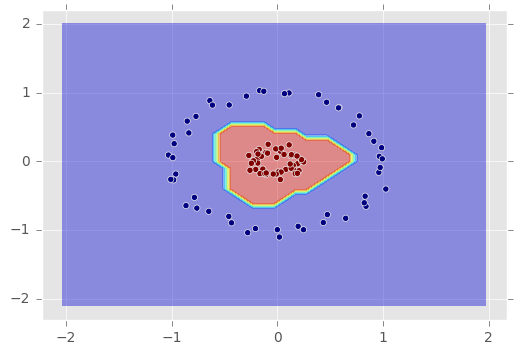

In [9]:
train = function([x, y], loss, updates=[(w1, w1 - 0.2 * grad_w1),
                                        (w2, w2 - 0.2 * grad_w2),
                                        (b1, b1 - 0.2 * grad_b1),
                                        (b2, b2 - 0.3 * grad_b2)])
for i in range(300):
    train(X, Y)
backprop_decision_boundary(predict, X, Y, True)